In [2]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests

In [3]:
# Make a GET request to the specified URL
url = "https://api.beta.ons.gov.uk/v1/datasets"

response = requests.get(url)

# Print the response as JSON
response.json()

{'items': [{'contacts': [{'email': 'qualityoflife@ons.gov.uk',
     'name': 'Will Shufflebottom, Owain Birrell, Pavan Bains and Geeta Kerai',
     'telephone': '+44 300 0671543'}],
   'description': 'Seasonally and non seasonally-adjusted quarterly estimates of life satisfaction, feeling that the things done in life are worthwhile, happiness and anxiety in the UK.',
   'keywords': ['well-being'],
   'id': 'wellbeing-quarterly',
   'last_updated': '2023-12-13T09:40:24.204Z',
   'links': {'editions': {'href': 'https://api.beta.ons.gov.uk/v1/datasets/wellbeing-quarterly/editions'},
    'latest_version': {'href': 'https://api.beta.ons.gov.uk/v1/datasets/wellbeing-quarterly/editions/time-series/versions/9',
     'id': '9'},
    'self': {'href': 'https://api.beta.ons.gov.uk/v1/datasets/wellbeing-quarterly'},
    'taxonomy': {'href': 'https://api.beta.ons.gov.uk/v1/peoplepopulationandcommunity/wellbeing'}},
   'methodologies': [{'href': 'https://www.ons.gov.uk/peoplepopulationandcommunity/wel

In [4]:
ons_url = "https://api.beta.ons.gov.uk/v1/datasets"
data_set = "uk-spending-on-cards"

In [5]:
def get_latest_version(data_set, root_url = "https://api.beta.ons.gov.uk/v1/datasets"):
    """Fetch the latest version information for a given dataset from the ONS API."""
    url = f"{root_url}/{data_set}"
    response = requests.get(url)
    latest_url = response.json()["links"]["latest_version"]["href"]
    print(latest_url)
    response = requests.get(latest_url)
    return response.json(), latest_url

In [6]:
get_latest_version(data_set)[0]
url_to_use = get_latest_version(data_set)[1]

https://api.beta.ons.gov.uk/v1/datasets/uk-spending-on-cards/editions/time-series/versions/130
https://api.beta.ons.gov.uk/v1/datasets/uk-spending-on-cards/editions/time-series/versions/130


In [7]:
def find_dimensions(url):
    response = requests.get(url + "/dimensions")

    items = response.json().get("items")

    dims = {}

    for item in items:
        id = item['links']['options']['id']
        options_url = f"{url}/dimensions/{id}/options"
        option_response = requests.get(options_url)
        option = option_response.json()
        option_descriptions = {
            item["option"]: item['label'] for item in option['items']
        }
        dims[id] = option_descriptions

    return(dims)

In [8]:
valid_dims = find_dimensions(url_to_use)

valid_dims

{'category': {'aggregate': 'Aggregate',
  'delayable': 'Delayable',
  'social': 'Social',
  'staple': 'Staple',
  'work-related': 'Work Related'},
 'daymonth': {'31-12': '31-12',
  '30-12': '30-12',
  '29-12': '29-12',
  '28-12': '28-12',
  '27-12': '27-12',
  '24-12': '24-12',
  '23-12': '23-12',
  '22-12': '22-12',
  '21-12': '21-12',
  '20-12': '20-12',
  '19-12': '19-12',
  '18-12': '18-12',
  '17-12': '17-12',
  '16-12': '16-12',
  '15-12': '15-12',
  '14-12': '14-12',
  '13-12': '13-12',
  '12-12': '12-12',
  '11-12': '11-12',
  '10-12': '10-12'},
 'geography': {'K02000001': 'United Kingdom'},
 'time': {'2024': '2024',
  '2023': '2023',
  '2022': '2022',
  '2021': '2021',
  '2020': '2020'}}

In [13]:
selected_request = {'category' : 'aggregate', 'daymonth' : '31-01', 'geography': 'K02000001', 'time': '*'}

def return_data(url, request: dict):

    response = requests.get(url + "/observations", params = request)

    if (response.status_code != 200):
        print("Request not valid please check parameters")
        return pd.DataFrame()

    observations = response.json()['observations']

    variable = [key for key, value in request.items() if value == '*'][0]

    summary = []
    for observation in observations:
        id = next(iter(observation['dimensions'].values()))['label']
        summary.append({variable: id, "observation": observation["observation"]})
    df = pd.DataFrame(summary)

    for name in request.keys():
        if (name in df.columns):
            next
        else:
            df[name] = request[name]

    df = df[df['observation'] != ""]

    df['observation'] = pd.to_numeric(df['observation'], errors='coerce')

    return df

In [14]:
def return_timeseries(url, category = 'aggregate', geography = 'K02000001'):
    years = find_dimensions(url)['time'].values()

    all_data = pd.DataFrame()
    for year in years:
        year_data = return_data(url, {'category' : category, 'daymonth' : '*', 'geography': geography, 'time': year})
        all_data = pd.concat([all_data, year_data])

    all_data['date'] = pd.to_datetime(all_data['daymonth'].astype(str) + '-' + all_data['time'].astype(str), dayfirst= True)

    all_data = all_data.sort_values('date', ascending= True).reset_index()

    return(all_data.drop(columns= ['index', 'daymonth', 'time']))

In [17]:
timeseries = return_timeseries(url_to_use, 'delayable')

timeseries.head()

,observation,category,geography,date
0,114.994943,delayable,K02000001,2020-01-13
1,111.774664,delayable,K02000001,2020-01-14
2,110.651491,delayable,K02000001,2020-01-15
3,109.153700,delayable,K02000001,2020-01-16
4,107.707179,delayable,K02000001,2020-01-17


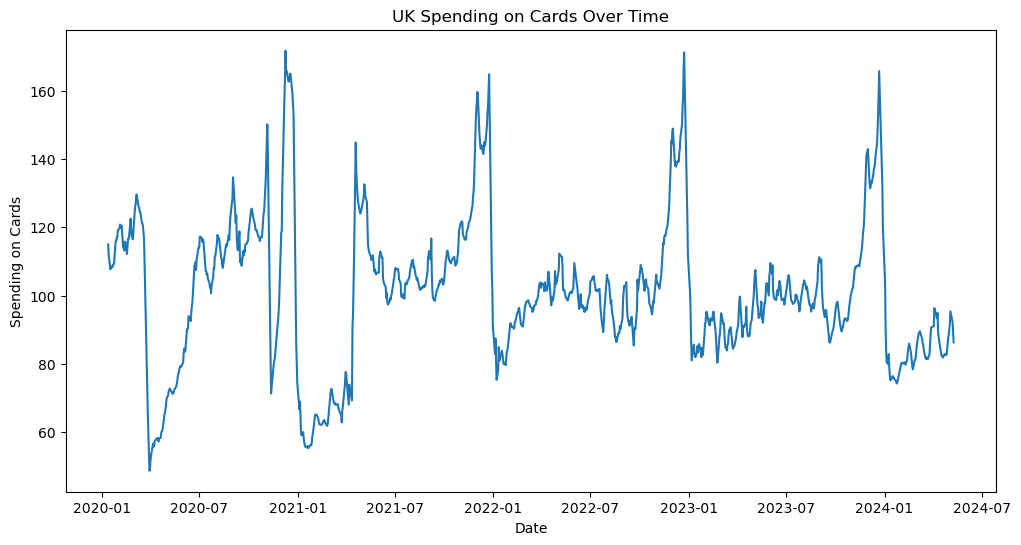

In [18]:
plt.figure(figsize=(12,6))
sns.lineplot(data=timeseries, x='date', y='observation')
plt.title('UK Spending on Cards Over Time')
plt.xlabel('Date')
plt.ylabel('Spending on Cards')
plt.show()